Preamble here:

Start with an explanation of PINNs: 

    1) What are regular neural networks: stuff about training functions, tuning weights, finding minima, minimizing loss with different loss functions
    2) What makes PINNs different?

Can start with the table from the start of the video explaining the use cases of neurodiffeq. 

Move onto basic examples of neurodiffeq.


In [ ]:
try:
    import neurodiffeq
except:
    import os
    os.system("pip install neurodiffeq")

In [2]:
try:
    import pysr
except ImportError:
    import subprocess
    import sys

    print("Installing Julia and PySR. This might take some time...")

    shell_script = '''
    # @title Install Julia and PySR (Takes some time)
    %%shell
    set -e

    #---------------------------------------------------#
    JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
    JULIA_PACKAGES="IJulia BenchmarkTools"
    JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
    JULIA_NUM_THREADS=2
    #---------------------------------------------------#

    if [ -z `which julia` ]; then
        # Install Julia
        JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
        echo "Installing Julia $JULIA_VERSION..."
        BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
        URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
        wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
        tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
        rm /tmp/julia.tar.gz

        # Install Packages
        nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
        if [ $GPU -eq 1 ]; then
        JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
        fi
        for PKG in `echo $JULIA_PACKAGES`; do
        echo "Installing Julia package $PKG..."
        julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
        done

        # Install kernel and rename it to "julia"
        echo "Installing IJulia kernel..."
        julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
            "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
        KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
        KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
        mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

        echo ''
        echo "Successfully installed `julia -v`!"
    fi
    '''

    process = subprocess.Popen(shell_script, shell=True, executable='/bin/bash')
    process.wait()

    subprocess.run([sys.executable, '-m', 'pip', 'install', '-U', 'pysr'])
    subprocess.run([sys.executable, '-m', 'pysr', 'install'])


In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from neurodiffeq.neurodiffeq import safe_diff as diff
from neurodiffeq.ode import solve, solve_system
from neurodiffeq.solvers import Solver1D
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.conditions import IVP

import matplotlib.pyplot as plt
from neurodiffeq.callbacks import ActionCallback
from neurodiffeq.networks import FCNN # fully-connect neural network
import torch.nn as nn                 # PyTorch neural network module
from neurodiffeq.generators import Generator1D
from neurodiffeq.conditions import NoCondition, IVP
import copy

%matplotlib inline

## The Diff Function

This is at the core of NeuroDiffEq

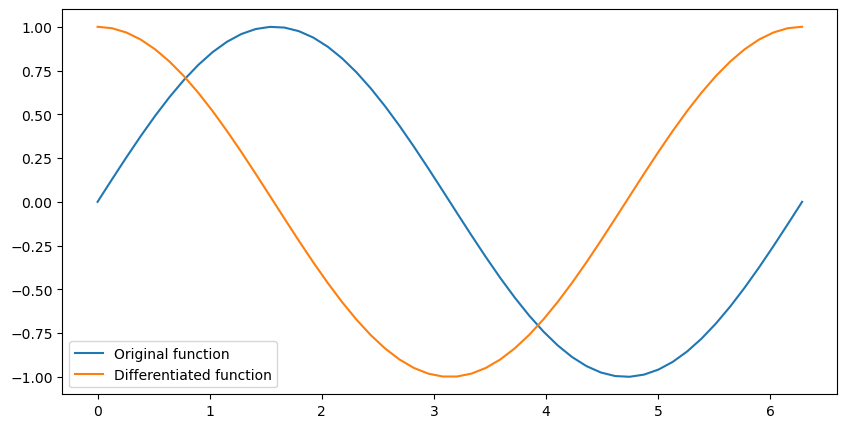

In [28]:
t = torch.linspace(0,2*torch.pi,50,requires_grad=True)
t = torch.reshape(t,(-1,1)) #The -1 reduces the dimension to a single dimension. This turns the input into a single column vector
u = torch.sin(t)
du_dt = neurodiffeq.diff(u,t)

plt.figure(figsize=(10,5))
plt.plot(t.detach().numpy(),u.detach().numpy(),label="Original function")
plt.plot(t.detach().numpy(),du_dt.detach().numpy(),label= "Differentiated function")
plt.legend()

## 1. Train for the Potential function

The problem consists on solving the differential equation using `neurodiffeq` and recover the potential $V$.

$$ \frac{d^2y}{dx^2} + \frac{dV}{dy} = 0 $$

When the potential, $V$, is unknown. The case at hand is the harmonic oscilator for which $dV/dy = ky$, where $k=2$, $\;\boxed{\Rightarrow V(y) = (k/2)y^2 = y^2}$. For this diff eq and this potential, the solution is $\boxed{y(x) = \sin(kx)}$

To deal with ODE systems, we **split it into ODE system**:

$$ \frac{dz}{dx} + \frac{dV}{dy} = 0 $$

$$ vy - \frac{dy}{dx} = 0 $$

**They define NNs for both systems** that take $x$ and output $y(x)$ (`net_xy`) and $x$ to output $dy/dx$ (`net_xvy`) respectively. They also define an auxiliary NN that takes $y$ and outputs $V(y)$ (`net_yV`). `net_xy` and `net_xvy` are the NNs of the solver, but `net_xvy` is internal to the system and has to be accessed via callbacks. **The interesting thing about this is that the NN is being trained on data from x and y, and manages to optimize decently well for V(y) as well**.



### Elements of `neurodiffeq`

**inputs of a solver**

- ODE/PDE System
- Condition/Parametrization
- DOmain Boundary/Point Generator
- Networks (opt, recommended)
- Optimizer 
- Loss Function
- (?) Callbacks

**outputs of a solver**
- Final/Last Solution
- Solution Viz
- Trace Plot

**generators**

In [4]:
## Generate data
k = 2.0
x_true = np.linspace(0, np.pi, 256)
# True data is y = sin(kx) + noise
y_true =  np.sin(k*x_true) + 0.2*np.random.randn(256)


## x --> y --> V
# independent --> dependant --> potential
# Specify the network architecture
net_xy = FCNN(
    hidden_units=(64, 64,), actv=nn.Tanh
) # this one takes x and outputs y(x)
net_xvy = FCNN(
    hidden_units=(64, 64,), actv=nn.Tanh
) # this takes x and outputs vy=dy/dx
net_yV = FCNN(
    hidden_units=(64, 64,), actv=nn.Tanh
) # This one takes y and outputs V(y)


nets = [net_xy, net_xvy] # this will be the diff eq in NN terms

# this is for sampling during the fit of the model ??
train_gen = Generator1D(size=128,  t_min=0.0, t_max=np.pi, method='equally-spaced-noisy')
valid_gen = Generator1D(size=128, t_min=0.0, t_max=np.pi, method='equally-spaced')


class Solver_withMSE(Solver1D):
  def __init__(self, x_true = None, y_true = None, alpha_init = 1, **kwargs):
    super().__init__(**kwargs) # inherit Solver1D __init__
    self.x_true = torch.tensor(x_true, requires_grad = True).view(-1,1)
    self.y_true = torch.tensor(y_true).view(-1,1)
    self.alpha_init = alpha_init
    self.b = -4

  # overwrite the `additional_loss` method from Solver1D to consider the mse as a term in the loss function
  def additional_loss(self, residual, funcs, coords):
    epochs = self.global_epoch
    max_epochs = self._max_local_epoch
    frac = epochs/max_epochs
    # alpha does annealing of the coefficient of mse loss becase we want the coefficient of the MSE loss to be higher when we start training
    # annealing: Allowing for the trainability to vary with the epoch N°. From high variability to low.
    alpha = (self.alpha_init-1)*np.exp(self.b*frac) - (self.alpha_init-1)*np.exp(self.b)*frac + 1
    batch = [self.x_true]
    funcs = [
    self.compute_func_val(n, c, *batch) for n, c in zip(self.nets, self.conditions)
    ]
    loss_mse = ((funcs[0]-self.y_true)**2).mean() # simple mean squared error loss. `funcs[0]` is the y prediction
    return alpha*loss_mse

class DualOptimizer():
  def __init__(self, optimizers):
    self.optimizers = optimizers

  def step(self, closure = None):
    for opt in self.optimizers:
      opt.step(closure)

  def zero_grad(self):
    for opt in self.optimizers:
      opt.zero_grad()



def system(y, vy, x):
  # We want to solve y'' + dV/dy = 0 but we frame it as a system of first order equations
  V = net_yV(y)
  eq1 = diff(V,y) + diff(vy,x,order = 1)
  eq2 = diff(y,x) - vy
  return [eq1, eq2]


conditions = [
    IVP(t_0=0.0, u_0=0.0),
    IVP(t_0=0.0, u_0=k),
]

opt_yx = torch.optim.Adam(set([p for net in nets for p in net.parameters()]), lr=1e-3, weight_decay=0.0001)
opt_potential = torch.optim.Adam(net_yV.parameters(), lr=1e-3)

dualoptimizer = DualOptimizer([opt_yx, opt_potential])

class DoSchedulerStep(ActionCallback):
    def __init__(self, scheduler):
        super().__init__()
        self.scheduler = scheduler

    def __call__(self, solver):
        self.scheduler.step()

class BestValidationCallback(ActionCallback):
    def __init__(self):
        super().__init__()
        self.best_potential = None

    def __call__(self, solver):
        if solver.metrics_history['train_loss'][-1] <= solver.lowest_loss:
            self.best_potential = copy.deepcopy(net_yV)


#scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1200, gamma=0.95)
#scheduler_cb = DoSchedulerStep(scheduler=scheduler)
potential_cb = BestValidationCallback()


solver = Solver_withMSE(
    x_true = x_true,
    y_true = y_true,
    alpha_init = 10,
    ode_system=system,
    conditions=conditions,
    t_min=0,
    t_max=np.pi, #- delta,
    optimizer = dualoptimizer,
    train_generator=train_gen,
    valid_generator=valid_gen,
    nets=nets,
    n_batches_valid=0,
)


In [5]:
solver.fit(max_epochs=15000, callbacks=[potential_cb])#, scheduler_cb])


Training Progress:   0%|          | 0/15000 [00:00<?, ?it/s]

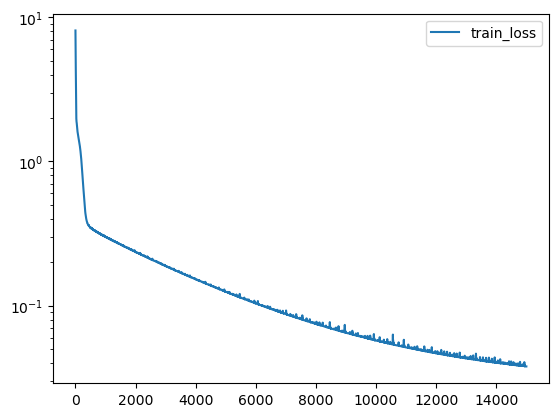

In [6]:
history = solver.metrics_history

plt.plot(history['train_loss'], label = 'train_loss')
#plt.plot(history['valid_loss'], label = 'valid_loss')
plt.legend()
plt.yscale('log')

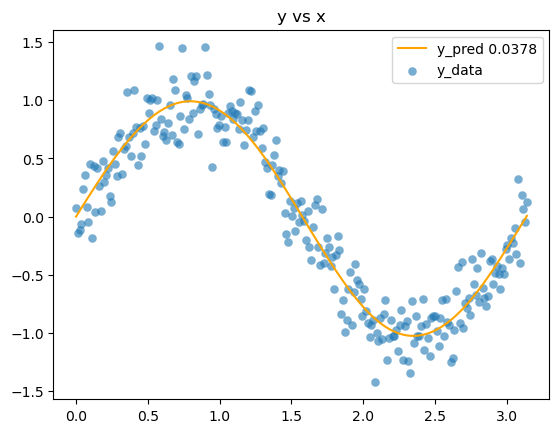

In [7]:
solution = solver.get_solution(best=True)
xs = np.linspace(0, np.pi, 256)
ys = solution(xs)[0]
mse1 = ((ys.cpu().detach()-y_true)**2).mean()
plt.plot(xs, ys.cpu().detach().numpy(), label = 'y_pred {:.4f}'.format(mse1), color = 'orange')
plt.scatter(x_true, y_true, label = 'y_data', lw = 0.1, alpha = 0.6)
plt.legend()
plt.title('y vs x')
plt.show()

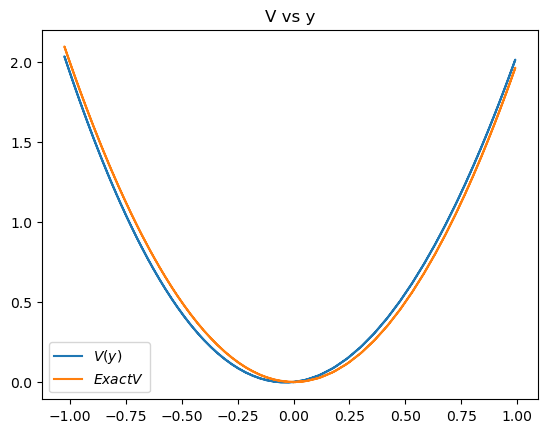

In [8]:
solution = solver.get_solution(best=True)
xs = torch.tensor(np.linspace(0, np.pi, 100)).view(-1,1)
ys = solution(xs)[0].view(-1,1)
Vs = potential_cb.best_potential(ys)
dVdy = diff(Vs, ys)
plt.plot(ys.cpu().detach().numpy(), Vs.cpu().detach().numpy() - Vs[0].item(), label = '$V(y)$')
#Exact potential = 1/2*k^2*y^2
plt.plot(ys.cpu().detach().numpy(), 0.5*(k*k)*ys.pow(2).cpu().detach().numpy(), label = '$Exact V$')
plt.legend()
plt.title('V vs y')
plt.show()

In [9]:
import numpy as np
solution = solver.get_solution(best=True)
xs = torch.tensor(np.linspace(0, np.pi, 100)).view(-1,1)
ys = solution(xs)[0].view(-1,1)
Vs = potential_cb.best_potential(ys)


X = ys.cpu().detach().numpy()
y = Vs.cpu().detach().numpy() - Vs[0].item()

from pysr import PySRRegressor

model_SR = PySRRegressor(
    niterations=50,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)
model_SR.set_params(extra_torch_mappings = {'inv(x)': lambda x: 1/x})

PySRRegressor.equations_ = None

In [10]:
model_SR.fit(X, y)

/home/carva/anaconda3/envs/LSSDSenv/lib/python3.11/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


/home/carva/anaconda3/envs/LSSDSenv/lib/python3.11/site-packages/pysr/julia_helpers.py:162: UserWarning: `torch` was loaded before the Julia instance started. This may cause a segfault when running `PySRRegressor.fit`. To avoid this, please run `pysr.julia_helpers.init_julia()` *before* importing `torch`. For updates, see https://github.com/pytorch/pytorch/issues/78829
  warnings.warn(
/home/carva/anaconda3/envs/LSSDSenv/lib/python3.11/site-packages/pysr/julia_helpers.py:208: UserWarning: Your system's Python library is static (e.g., conda), so precompilation will be turned off. For a dynamic library, try using `pyenv` and installing with `--enable-shared`: https://github.com/pyenv/pyenv/blob/master/plugins/python-build/README.md#building-with---enable-shared.
  warnings.warn(


Started!

Expressions evaluated per second: 2.690e+05
Head worker occupation: 39.5%. This is high, and will prevent efficient resource usage. Increase `ncyclesperiteration` to reduce load on head worker.
Progress: 723 / 750 total iterations (96.400%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           5.218e-01  1.594e+01  y = 1.0008
3           3.172e-01  2.489e-01  y = inv(cos(x₀))
5           3.234e-03  2.293e+00  y = ((x₀ * x₀) * 1.989)
7           2.911e-04  1.204e+00  y = (((x₀ + 0.077076) + x₀) * x₀)
9           2.652e-04  4.673e-02  y = (((x₀ + -0.059346) + x₀) * (x₀ + 0.068235))
10          8.230e-05  1.170e+00  y = ((x₀ + (0.060902 * cos(x₀))) * (x₀ + x₀))
12          5.162e-05  2.332e-01  y = ((x₀ + (0.060902 * cos(0.060902 + x₀))) * (x₀ + x₀))
13          4.959e-05  4.021e-02  y = ((x₀ + (x₀ * 0.99076)) * (x₀ + sin(0.061082 * cos(x₀))))
14          4.603e-05  

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          1.0007709   
	1         0.248877                                       inv(cos(x0))   
	2         2.292923                            ((x0 * x0) * 1.9889817)   
	3         1.203822                    (((x0 + 0.07707612) + x0) * x0)   
	4         0.046734   (((x0 + -0.05934593) + x0) * (x0 + 0.068235084))   
	5         1.169972        ((x0 + (0.06090186 * cos(x0))) * (x0 + x0))   
	6         0.233920  ((x0 + x0) * (x0 + (0.06108203 * cos(0.0610820...   
	7         0.040434  ((x0 + (x0 * 0.99075586)) * (x0 + (sin(0.06108...   
	8         0.072831  ((x0 + (0.083713606 * cos(-1.2773366 * (x0 + 0...   
	9         0.055356  ((x0 + (0.083713606 * sin(cos(-1.2773366 * (x0...   
	10  >>>>  1.362449  (x0 * ((x0 + ((x0 + sin(inv(cos(sin(cos(x0))))...   
	
	        loss  complexity  
	0   0.521805           1  
	1   0.317202           3  
	2   0.003234           5  
	3   0.000291           7  
	4   0.000265           9  
	5   0.000082          10  
	6   0.000052          12  
	7   0.000050          13  
	8   0.000046          14  
	9   0.000044          15  
	10  0.000011          16  
]

## 2. Train PINN on candidate potentials without data then validate with data

--------------------------------------------------------------------------------
Candidate potential before fitting:  1.00077090000000
--------------------------------------------------------------------------------


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Candidate potential after fitting:  1.00077090000000
--------------------------------------------------------------------------------
Candidate potential : 1.00077090000000 MSE with data : 15.7646797


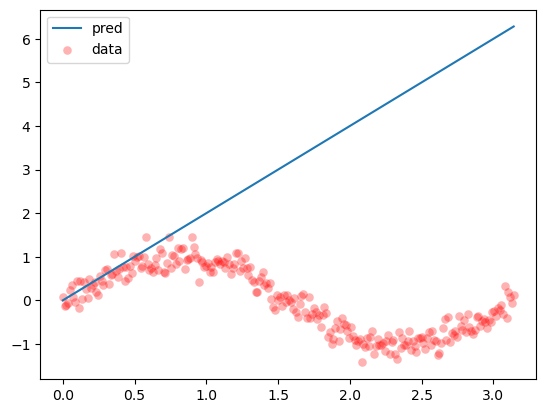

--------------------------------------------------------------------------------
Candidate potential before fitting:  1/cos(x0)
--------------------------------------------------------------------------------


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Candidate potential after fitting:  1/cos(x0)
--------------------------------------------------------------------------------
Candidate potential : 1/cos(x0) MSE with data : 14.3857689


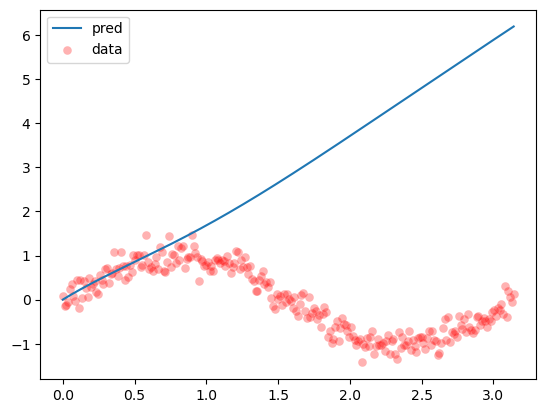

--------------------------------------------------------------------------------
Candidate potential before fitting:  1.9889817*x0**2
--------------------------------------------------------------------------------


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Candidate potential after fitting:  1.9889817*x0**2
--------------------------------------------------------------------------------
Candidate potential : 1.9889817*x0**2 MSE with data : 0.0395418


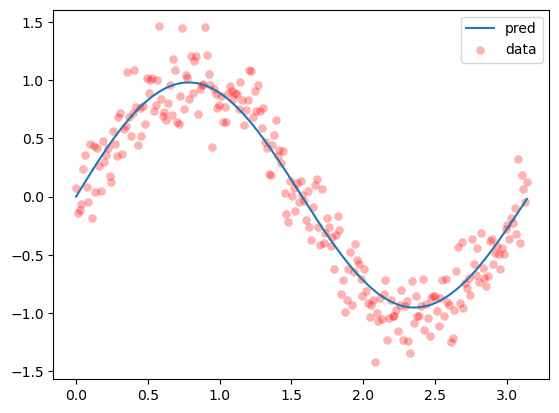

--------------------------------------------------------------------------------
Candidate potential before fitting:  x0*(2*x0 + 0.07707612)
--------------------------------------------------------------------------------


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Candidate potential after fitting:  x0*(2*x0 + 0.07707612)
--------------------------------------------------------------------------------
Candidate potential : x0*(2*x0 + 0.07707612) MSE with data : 0.0447475


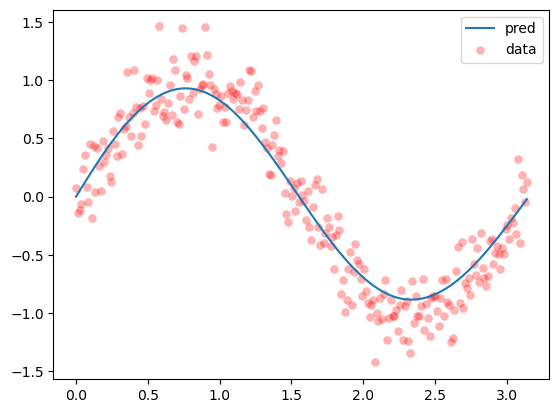

--------------------------------------------------------------------------------
Candidate potential before fitting:  (x0 + 0.068235084)*(2*x0 - 0.05934593)
--------------------------------------------------------------------------------


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Candidate potential after fitting:  (x0 + 0.068235084)*(2*x0 - 0.05934593)
--------------------------------------------------------------------------------
Candidate potential : (x0 + 0.068235084)*(2*x0 - 0.05934593) MSE with data : 0.0422537


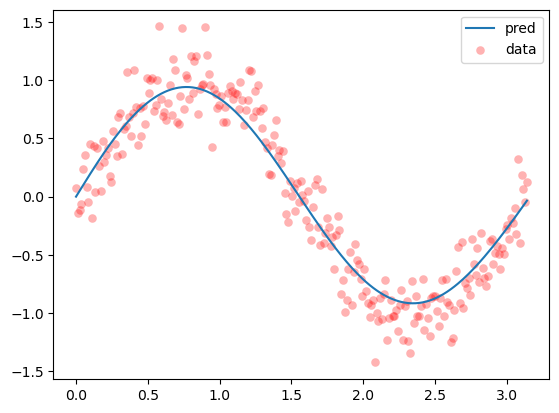

--------------------------------------------------------------------------------
Candidate potential before fitting:  2*x0*(x0 + 0.06090186*cos(x0))
--------------------------------------------------------------------------------


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Candidate potential after fitting:  2*x0*(x0 + 0.06090186*cos(x0))
--------------------------------------------------------------------------------
Candidate potential : 2*x0*(x0 + 0.06090186*cos(x0)) MSE with data : 0.0462869


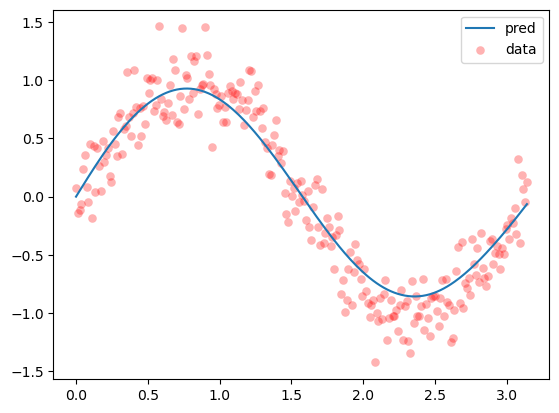

--------------------------------------------------------------------------------
Candidate potential before fitting:  2*x0*(x0 + 0.06108203*cos(x0 + 0.06108203))
--------------------------------------------------------------------------------


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Candidate potential after fitting:  2*x0*(x0 + 0.06108203*cos(x0 + 0.06108203))
--------------------------------------------------------------------------------
Candidate potential : 2*x0*(x0 + 0.06108203*cos(x0 + 0.06108203)) MSE with data : 0.0384479


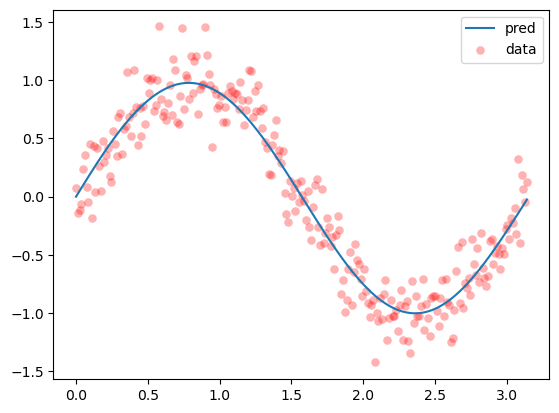

LOWEST MSE OBTAINED BY:  2*x0*(x0 + 0.06108203*cos(x0 + 0.06108203))  =  0.03844788450064151


In [38]:
top7_candidates = model_SR.pytorch(index = list(range(7))) # ?? this retrieves a torch-like symbolic expression that can be used to evaluate tensors
min_loss = 1e5 # this is just initializing the min_loss to a large value. You could do np.inf
min_loss_cand = None
for cand in top7_candidates:
  net_xy_cand = FCNN(
    hidden_units=(64, 64,), actv=nn.Tanh
  )

  def system_cand(y, x):
    V = cand(y).view(-1,1) # calculating the potential given by symbolic expression (that is trainable??)
    if V.shape == torch.Size([1, 1]):
      V = V * torch.ones_like(y)
    eq1 = diff(V,y) + diff(y,x,order = 2) # this is the whole DE of 2nd order
    return [eq1]

  nets_cand = [net_xy_cand]
  opt_yx_cand = torch.optim.Adam(set([p for net in nets_cand for p in net.parameters()]), lr=1e-3)
  conditions_cand = [
    IVP(t_0=0.0, u_0=0.0, u_0_prime = k),
  ]

  solver_cand = Solver1D(
    ode_system=system_cand,
    conditions=conditions_cand,
    t_min=0,
    t_max=np.pi,
    optimizer = opt_yx_cand,
    train_generator=train_gen,
    valid_generator=valid_gen,
    nets=nets_cand,
    n_batches_valid=0,
  )

  solver_cand.fit(max_epochs = 2000)
  solution_cand = solver_cand.get_solution(best = True)
  y_pred = solution_cand(x_true).cpu().detach().numpy()
  mse = ((y_pred - y_true)**2).mean()
  if mse < min_loss:
    min_loss = mse
    min_loss_cand = cand
  print('Candidate potential :',cand._expression_string, 'MSE with data : {:.7f}'.format(mse))
  plt.plot(x_true, y_pred, label = 'pred')
  plt.scatter(x_true, y_true, label = 'data', color = 'red', alpha = 0.3, lw = 0.1)
  plt.legend()
  plt.show()
  print('================================================')

print('LOWEST MSE OBTAINED BY: ',cand._expression_string, ' = ', min_loss)
print('================================================')

## 3. Finetuning candidates on the trained net

In [44]:
print('parameters before training: ',list(cand.named_parameters()))
print('expression before training: ',cand._expression_string)

parameters before training:  [('_node._args.2._args.1._args.0._value', Parameter containing:
tensor(0.0611, requires_grad=True))]
expression before training:  2*x0*(x0 + 0.06108203*cos(x0 + 0.06108203))


parameters before training:  [('_node._value', Parameter containing:
tensor(1.0008, requires_grad=True))]
expression before training:  1.00077090000000


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

parameters after training:  [('_node._value', Parameter containing:
tensor(1.0008, requires_grad=True))]
Candidate potential : 1.00077090000000 MSE : 0.4638643 Lowest Loss : 2.0182242


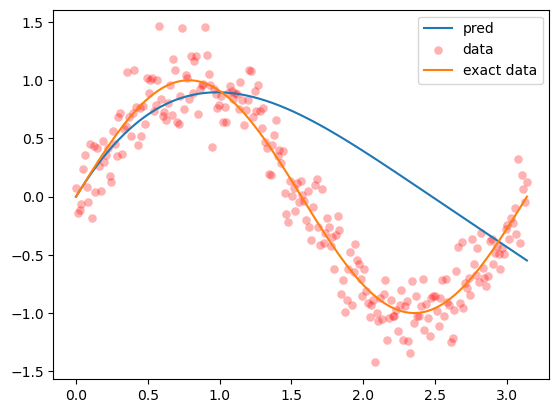

parameters before training:  []
expression before training:  1/cos(x0)


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

parameters after training:  []
Candidate potential : 1/cos(x0) MSE : 15.6867440 Lowest Loss : 2952.6839643


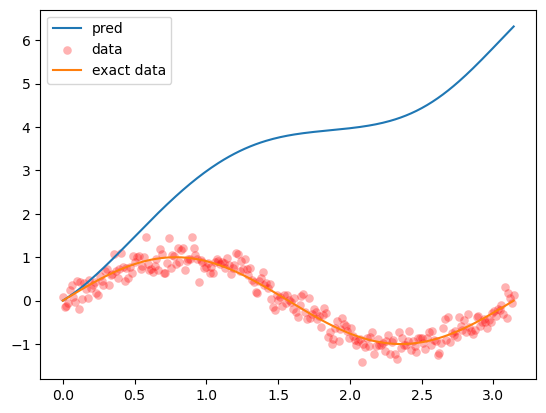

parameters before training:  [('_node._args.0._value', Parameter containing:
tensor(1.9890, requires_grad=True))]
expression before training:  1.9889817*x0**2


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

parameters after training:  [('_node._args.0._value', Parameter containing:
tensor(1.9003, requires_grad=True))]
Candidate potential : 1.9889817*x0**2 MSE : 0.0416160 Lowest Loss : 0.0432265


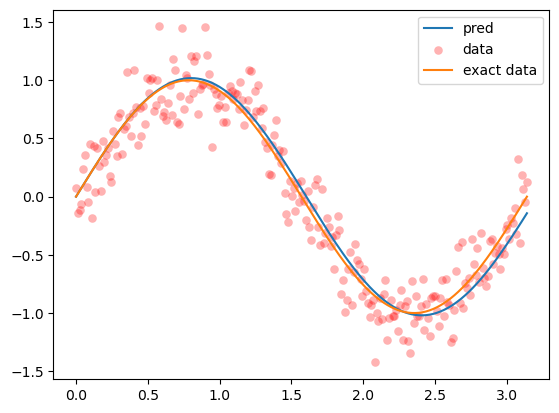

parameters before training:  [('_node._args.1._args.0._value', Parameter containing:
tensor(0.0771, requires_grad=True))]
expression before training:  x0*(2*x0 + 0.07707612)


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

parameters after training:  [('_node._args.1._args.0._value', Parameter containing:
tensor(-0.0426, requires_grad=True))]
Candidate potential : x0*(2*x0 + 0.07707612) MSE : 0.0383987 Lowest Loss : 0.0404347


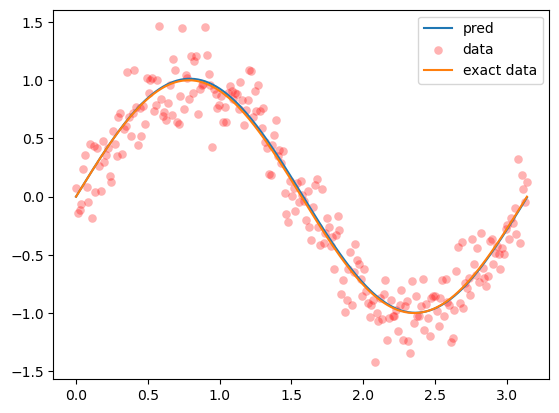

parameters before training:  [('_node._args.0._args.0._value', Parameter containing:
tensor(0.0682, requires_grad=True)), ('_node._args.1._args.0._value', Parameter containing:
tensor(-0.0593, requires_grad=True))]
expression before training:  (x0 + 0.068235084)*(2*x0 - 0.05934593)


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

parameters after training:  [('_node._args.0._args.0._value', Parameter containing:
tensor(0.0334, requires_grad=True)), ('_node._args.1._args.0._value', Parameter containing:
tensor(-0.0942, requires_grad=True))]
Candidate potential : (x0 + 0.068235084)*(2*x0 - 0.05934593) MSE : 0.0383023 Lowest Loss : 0.0403929


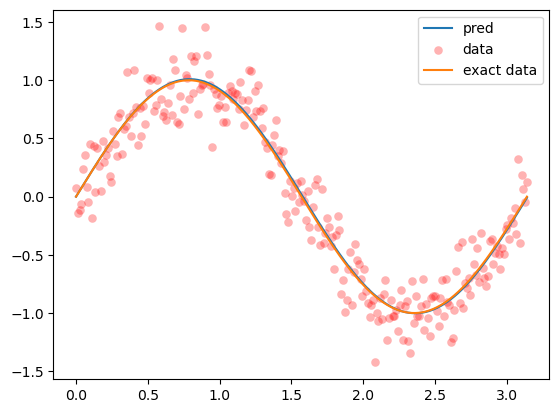

parameters before training:  [('_node._args.2._args.1._args.0._value', Parameter containing:
tensor(0.0609, requires_grad=True))]
expression before training:  2*x0*(x0 + 0.06090186*cos(x0))


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

parameters after training:  [('_node._args.2._args.1._args.0._value', Parameter containing:
tensor(-0.0207, requires_grad=True))]
Candidate potential : 2*x0*(x0 + 0.06090186*cos(x0)) MSE : 0.0382746 Lowest Loss : 0.0401914


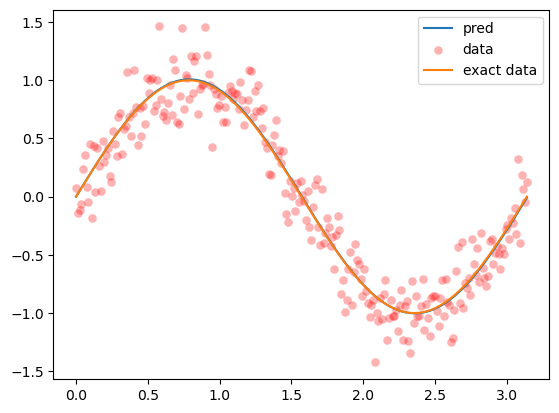

parameters before training:  [('_node._args.2._args.1._args.0._value', Parameter containing:
tensor(0.0611, requires_grad=True))]
expression before training:  2*x0*(x0 + 0.06108203*cos(x0 + 0.06108203))


Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

parameters after training:  [('_node._args.2._args.1._args.0._value', Parameter containing:
tensor(-0.0291, requires_grad=True))]
Candidate potential : 2*x0*(x0 + 0.06108203*cos(x0 + 0.06108203)) MSE : 0.0383130 Lowest Loss : 0.0402037


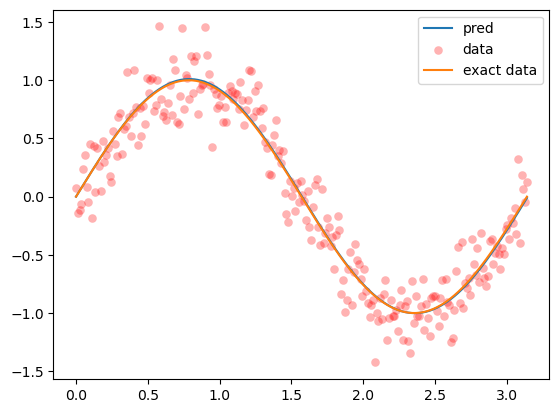

In [45]:
top7_candidates = model_SR.pytorch(index = list(range(7)))

for cand in top7_candidates:
  net_xy_cand = FCNN(
    hidden_units=(64, 64,), actv=nn.Tanh
  )

  def system_cand(y, x):
    V = cand(y).view(-1,1)
    if V.shape == torch.Size([1, 1]):
      V = V * torch.ones_like(y)
    eq1 = diff(V,y) + diff(y,x,order = 2)
    return [eq1]

  print('parameters before training: ',list(cand.named_parameters()))
  print('expression before training: ',cand._expression_string)
  nets_cand = [copy.deepcopy(net_xy)] # changed
  opt_yx_cand = torch.optim.Adam(set([p for net in nets_cand for p in net.parameters()]), lr=1e-3, weight_decay = 0.0001)
  conditions_cand = [
    IVP(t_0=0.0, u_0=0.0, u_0_prime = 2.0),
  ]
  if len(list(cand.parameters()))>0:
    opt_cand = torch.optim.Adam(cand.parameters(), lr=1e-2)
    dualoptimizer_cand = DualOptimizer([opt_yx_cand, opt_cand])
    opt_final = dualoptimizer_cand
  else:
    opt_final = opt_yx_cand

  solver_cand = Solver_withMSE(
    x_true = x_true,
    y_true = y_true,
    ode_system=system_cand,
    conditions=conditions_cand,
    t_min=0,
    t_max=np.pi,
    optimizer = opt_final,
    train_generator=train_gen,
    valid_generator=valid_gen,
    nets=nets_cand,
    n_batches_valid=0,
  )
  solver_cand.fit(max_epochs = 2000)
  print('parameters after training: ',list(cand.named_parameters()))
  solution_cand = solver_cand.get_solution(best = True)
  y_pred = solution_cand(x_true).cpu().detach().numpy()
  print('Candidate potential :',cand._expression_string, 'MSE : {:.7f}'.format(((y_pred - y_true)**2).mean()), 'Lowest Loss : {:.7f}'.format(solver_cand.lowest_loss))#, solver_cand.lowest_loss)
  plt.plot(x_true, y_pred, label = 'pred')
  plt.scatter(x_true, y_true, label = 'data', color = 'red', alpha = 0.3, lw = 0.1)
  plt.plot(x_true, np.sin(2*x_true), label = 'exact data')
  plt.legend()
  plt.show()
  print('================================================')